In [1]:
#install packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import os
from scipy.stats import anderson 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from scipy.stats import zscore

In [2]:
#set output folder for figures
output_directory = 'output_figures'
os.makedirs(output_directory, exist_ok=True)

In [3]:
# Load data into dataframe
df = pd.read_csv('all_age_regression.csv')

# Filter for males and females separately for ns1 and ns2
ns2_m = df[(df['sex'] == 1) & (df['ns'] == 1)].groupby('animal_idx').head(3)
ns4_m = df[(df['sex'] == 1) & (df['ns'] == 2)].groupby('animal_idx').head(3)
ns4_m['session_number'] = ns4_m.groupby('animal_idx')['age'].rank(method='min').astype(int)
ns4_m = ns4_m.sort_values(by=['animal_idx', 'sess_num'])

ns2_f = df[(df['sex'] == 2) & (df['ns'] == 1)].groupby('animal_idx').head(3)
ns4_f = df[(df['sex'] == 2) & (df['ns'] == 2)].groupby('animal_idx').head(3)
ns4_f['session_number'] = ns4_f.groupby('animal_idx')['age'].rank(method='min').astype(int)
ns4_f = ns4_f.sort_values(by=['animal_idx', 'sess_num'])


In [4]:
#loop through data sets and create new columns with logs for alpha and beta
dfs = [ns2_m, ns4_m, ns2_f, ns4_f]

for df in dfs:
    df['log_alpha_positive'] = np.log(df['alpha_positive'])
    df['log_beta'] = np.log(df['beta'])

In [5]:
# Identifying and dropping outliers
dataframes = [('ns2_m', ns2_m), ('ns4_m', ns4_m), ('ns2_f', ns2_f), ('ns4_f', ns4_f)]

# Columns of interest for outlier detection
columns_of_interest = ['reg_trial_intercept', 'reg_trial_oneback', 'reg_trial_twoback', 'reg_trial_rl', 
                       'reg_repeat_intercept', 'reg_repeat_main', 'reg_repeat_reward', 'reg_nrepeat_reward', 
                       'reg_repeat_rl', 'reg_reward_intercept', 'reg_reward_main', 'reg_reward_repeat', 
                       'reg_nreward_repeat', 'reg_reward_rl', 's1', 's2', 's3', 'log_alpha_positive', 'log_beta']

# Set a threshold for identifying outliers
threshold = 3.0

# Loop through each dataframe
for name, df in dataframes:
    outlier_indices = set()
    
    # Identify outliers for each column and accumulate indices
    for column in columns_of_interest:
        z_scores = zscore(df[column])
        outliers = np.where(np.abs(z_scores) > threshold)[0]
        outlier_indices.update(outliers)
        
    # Convert the set to a sorted list and drop outliers
    outlier_indices = sorted(outlier_indices)
    df.drop(df.index[outlier_indices], inplace=True)
    
    print(f"Dropped outliers for {name}: {outlier_indices}")


Dropped outliers for ns2_m: [50, 62, 69, 71, 72, 91, 92]
Dropped outliers for ns4_m: [6, 23, 35, 36, 47, 48, 49, 54, 62, 84]
Dropped outliers for ns2_f: [10, 25]
Dropped outliers for ns4_f: [7, 14, 17, 22, 31]


In [6]:
#create merged data frames for session effect figures
merged_df_male = pd.concat([ns2_m, ns4_m])
merged_df_female = pd.concat([ns2_f, ns4_f])

In [7]:
#only use the first 3 sessions of each set size are used
merged_df_male['real_sess'] = merged_df_male.groupby('animal_idx')['age'].rank(method='min').astype(int)
merged_df_female['real_sess'] = merged_df_female.groupby('animal_idx')['age'].rank(method='min').astype(int)

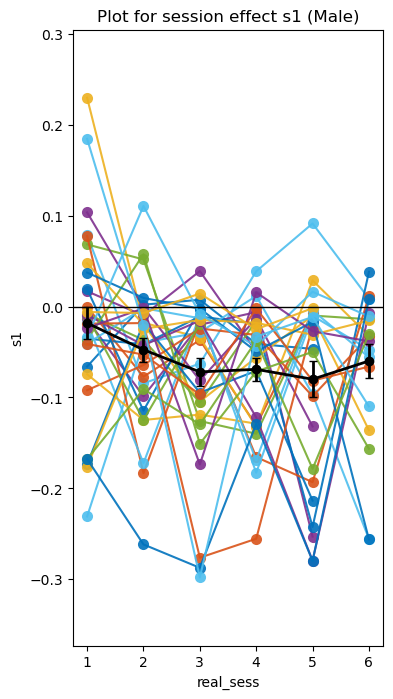

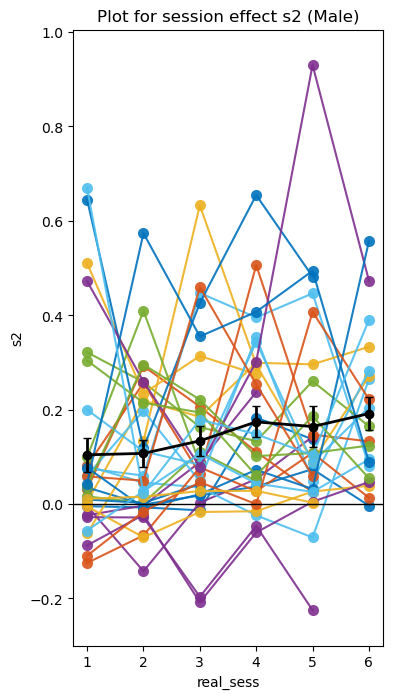

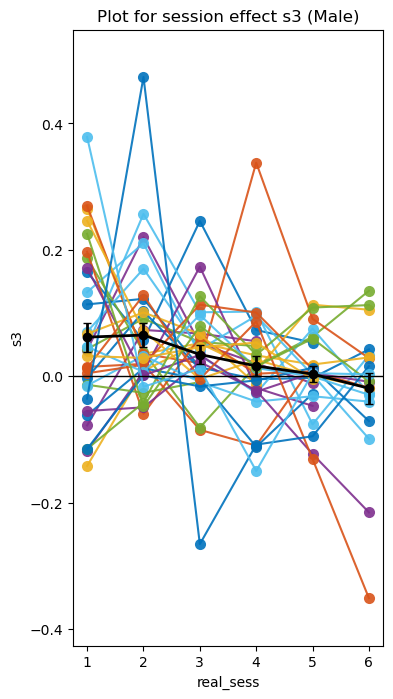

In [8]:
# Columns of interest for plotting across sessions - change these depending on which parameter is dependent
columns_of_interest = ['s1','s2','s3']

# Set specific colors and have them correspond to animal_ids
hek_colors = ['#0072BD', '#4DBEEE', '#7E2F8E', '#D95319', '#EDB120', '#77AC30']
palette = sns.color_palette(hek_colors, n_colors=len(merged_df_male['animal_idx'].unique()))

# Loop through each column in columns_of_interest
for column in columns_of_interest:
    plt.figure(figsize=(4, 8))

    # Set the desired y-axis limits
    y_min = merged_df_male[column].min() - 0.075  # Adjust the value as needed (more for strategy parameters)
    y_max = merged_df_male[column].max() + 0.075  

    # Plot individual data points for each animal
    sns.lineplot(x='real_sess', y=column, hue='animal_idx', data=merged_df_male, marker='o', markersize=8, 
                 errorbar=None, palette=palette, alpha=0.9, markeredgecolor='none')

    # Calculate the overall average and SEM for each session
    average_values = merged_df_male.groupby('real_sess')[column].mean()
    sem_values = merged_df_male.groupby('real_sess')[column].sem()

    # Plot the average line with SEM error bars
    plt.errorbar(average_values.index, average_values, yerr=sem_values, fmt='-o', color='black', capsize=3, 
                 label='Average ± SEM', linewidth=2)

    plt.gca().set_xticks(merged_df_male['real_sess'].unique())

    # Add a darker line at y=0 (only for strategy parameters)
    plt.axhline(y=0, color='black', linewidth=1)

    # Display R² and p-values as text annotations (if needed, otherwise remove these lines)
    # plt.text(0.95, 0.85, f'R² = {r_value**2:.2f}', transform=plt.gca().transAxes, ha='right', fontsize=10)
    # plt.text(0.95, 0.8, f'p = {p_value:.4f}', transform=plt.gca().transAxes, ha='right', fontsize=10)

    # Remove the legend for the individual lines
    plt.legend().set_visible(False)

    # Set the y-axis limits
    plt.ylim(y_min, y_max)

    # Set title and display the plot
    plt.title(f'Plot for session effect {column} (Male)')
    plt.grid(False)
    plt.show()

    # Save the figure as an SVG file with "male" in the file name
    #output_file_path = os.path.join(output_directory, f'plot_{column}_male_sesseffect.svg')
    #plt.savefig(output_file_path, bbox_inches='tight', dpi=300)


In [32]:
#run mixed linear models for each group separately for sess_num
parameters = ['log_alpha_positive', 'log_beta', 's1', 's2', 's3']
dataframes = [('male', merged_df_male), ('female', merged_df_female)]

# Loop through each parameter and each dataframe
for param in parameters:
    for df_name, df in dataframes:
        mixed_model = smf.mixedlm(f"{param} ~ real_sess", df, groups=df['animal_idx']) # , re_formula="1 + age"
        result = mixed_model.fit()
        
        # Print the results summary
        print(f"Results for {param} in {df_name}:")
        print(result.summary())
        print("\n" + "="*80 + "\n")


Results for log_alpha_positive in male:
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_alpha_positive
No. Observations: 173     Method:             REML              
No. Groups:       32      Scale:              2.7298            
Min. group size:  3       Log-Likelihood:     -340.4826         
Max. group size:  6       Converged:          Yes               
Mean group size:  5.4                                           
------------------------------------------------------------------
             Coef.    Std.Err.      z      P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept    -4.815      0.296   -16.287   0.000   -5.395   -4.236
real_sess    -0.094      0.077    -1.213   0.225   -0.246    0.058
Group Var     0.257      0.129                                    



Results for log_alpha_positive in female:
             Mixed Linear Model Regression Results
Model:            Mix

/srv/conda/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/srv/conda/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warning

Results for log_beta in male:
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_beta 
No. Observations: 173     Method:             REML     
No. Groups:       32      Scale:              0.6837   
Min. group size:  3       Log-Likelihood:     -216.4376
Max. group size:  6       Converged:          Yes      
Mean group size:  5.4                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.711    0.141 12.098 0.000  1.434  1.989
real_sess     0.053    0.039  1.360 0.174 -0.023  0.128
Group Var     0.006    0.035                           



Results for log_beta in female:
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_beta
No. Observations: 67      Method:             REML    
No. Groups:       15      Scale:              0.6396  
Min. 

/srv/conda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/srv/conda/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/srv/conda/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


Results for s1 in male:
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: s1      
No. Observations: 173     Method:             REML    
No. Groups:       32      Scale:              0.0070  
Min. group size:  3       Log-Likelihood:     169.7161
Max. group size:  6       Converged:          Yes     
Mean group size:  5.4                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   -0.024    0.015 -1.637 0.102 -0.054  0.005
real_sess   -0.010    0.004 -2.529 0.011 -0.018 -0.002
Group Var    0.001    0.006                           



Results for s1 in female:
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: s1     
No. Observations: 67      Method:             REML   
No. Groups:       15      Scale:              0.0070 
Min. group size:  1       Log-Lik

/srv/conda/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/srv/conda/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimizat

Results for s3 in male:
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: s3      
No. Observations: 173     Method:             REML    
No. Groups:       32      Scale:              0.0095  
Min. group size:  3       Log-Likelihood:     147.4394
Max. group size:  6       Converged:          No      
Mean group size:  5.4                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.087    0.017  5.188 0.000  0.054  0.120
real_sess   -0.017    0.005 -3.810 0.000 -0.026 -0.008
Group Var    0.000    0.005                           



Results for s3 in female:
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: s3     
No. Observations: 67      Method:             REML   
No. Groups:       15      Scale:              0.0099 
Min. group size:  1       Log-Lik

/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 4.042686
  warnings.warn(msg, ConvergenceWarning)
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/srv/conda/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map ins